# Convolutional Network for cats and dogs classification. This is  a full pipeline with the model architecture, training and evaluation using Kaggle Cat and Dogs dataset.

In [1]:
#Start with cheking if GPUs are avalible

import tensorflow as tf

# Check if GPUs are availible:
if tf.config.list_physical_devices('GPU'):
     print("GPU is available.")
else:
     print("GPU is not available.")

2023-09-08 12:18:03.055160: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-08 12:18:03.564659: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64:/usr/local/:
2023-09-08 12:18:03.564699: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64:/usr/local/:
2023-09-08 12:18:03.564703: W tensorflow/compiler/

GPU is available.


2023-09-08 12:18:04.279660: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-08 12:18:04.279810: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-08 12:18:04.300644: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-08 12:18:04.300791: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-08 12:18:04.300907: I tensorflow/compiler/xla/stream_executo

In [2]:
#Download Toloka cats and dogs toy datase (https://www.kaggle.com/datasets/valentinbiryukov/toloka-cats-and-dogs-toy-dataset) from Kaggle to local directory.
#Load it to Jupyter notebook

import os

file_name = "/home/semc/Aygul_DL/archive.zip"  # location and name of data file
#file_size = os.path.getsize(file_name)

print(f'User uploaded file "{file_name}" ')

User uploaded file "/home/semc/Aygul_DL/archive.zip" 


In [3]:
# Work with zipped file using pandas

import pandas as pd

# Reading from a zipped CSV file:
data = pd.read_csv(file_name, compression='zip', encoding='utf-8', header=0, sep='\t')

# Display the first few rows to understand the structure:
data.head()

,url,label
0,https://tlk.s3.yandex.net/dataset/cats_vs_dogs...,dog
1,https://tlk.s3.yandex.net/dataset/cats_vs_dogs...,dog
2,https://tlk.s3.yandex.net/dataset/cats_vs_dogs...,dog
3,https://tlk.s3.yandex.net/dataset/cats_vs_dogs...,dog
4,https://tlk.s3.yandex.net/dataset/cats_vs_dogs...,dog


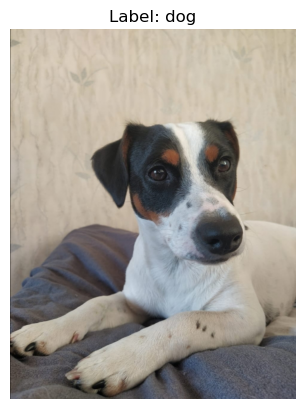

In [5]:
# Show some images with the labels

import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# Assuming 'url' is the column containing the URLs to the images
# and 'label' is the column containing the labels:
for url, label in zip(data['url'][1:2], data['label'][1:2]):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    plt.imshow(image)
    plt.axis('off') # To remove axes
    plt.title(f'Label: {label}', color='black') # Display the label as the title
    plt.show()

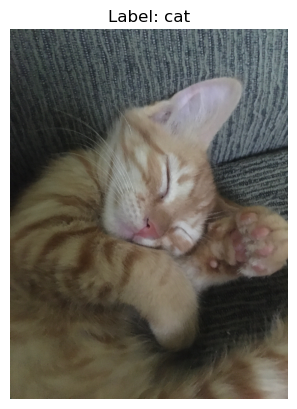

In [6]:
# Split the data to trainig and testing datasets

from sklearn.model_selection import train_test_split

# Split the data into 80% training and 20% testing:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Now training and testing sets can be accessed as separate DataFrames
# Show the first three images and labels from the training set:
for url, label in zip(train_data['url'][:1], train_data['label'][:1]):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    plt.imshow(image)
    plt.axis('off') # To remove axes
    plt.title(f'Label: {label}', color='black') # Display the label as the title
    plt.show()

In [7]:
#Function for normalizing and resizing images:
from PIL import Image
import numpy as np

def normalize_and_resize_image(url, shape=(224, 224)):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content)).resize(shape)
    image_array = np.array(image)
    return image_array / 255.0

#Function for downloading and preprocessing images in parallele to speed up the process:
from concurrent.futures import ThreadPoolExecutor

def download_and_preprocess_images(image_urls):
    with ThreadPoolExecutor() as executor:
        images = list(executor.map(normalize_and_resize_image, image_urls))
    return np.stack(images)

In [8]:
# Download and preprocess trainig data (X)

train_image_urls = train_data['url'].values
test_image_urls = test_data['url'].values

X_train = download_and_preprocess_images(train_image_urls)
X_test = download_and_preprocess_images(test_image_urls)

In [9]:
# Convert labels (cat, dog) to integegs
from sklearn.preprocessing import LabelEncoder

# Create a label encoder object:
le = LabelEncoder()

# Fit the encoder on the labels in data (both train and test) to know what unique labels exist and convert labels to integers:
le.fit(data['label'])

# Transform both the training and test labels into integers:
y_train = le.transform(train_data['label'])
y_test = le.transform(test_data['label'])

In [10]:
# Architecture of convolutional neural network

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Initialize the model
model = Sequential()

# Add the Convolution layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))

# Add a MaxPooling layer to reduce dimensionality
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add another Convolution layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

# Add another MaxPooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add a Flatten layer to convert the 2D matrix data to a vector
model.add(Flatten())

# Add a Dense layer with 128 neurons
model.add(Dense(128, activation='relu'))

# Add a Dropout layer for regularization
model.add(Dropout(0.5))

# Add the output layer with one neuron, since it's a binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model Summary to review the architecture
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 128)               2

2023-09-08 12:22:56.721185: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-08 12:22:56.853686: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-08 12:22:56.853826: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-08 12:22:56.853936: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

Epoch 1/30


2023-09-08 12:26:26.362417: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8400
2023-09-08 12:26:26.812516: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f45b815fcb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-08 12:26:26.812531: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2023-09-08 12:26:26.812536: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): Quadro RTX 5000, Compute Capability 7.5
2023-09-08 12:26:26.815379: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-08 12:26:26.889024: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


33/33 [==============================] - 3s 15ms/step - loss: 1.2698 - accuracy: 0.4969 - val_loss: 0.6935 - val_accuracy: 0.4634
Epoch 2/30
33/33 [==============================] - 0s 9ms/step - loss: 0.6921 - accuracy: 0.6522 - val_loss: 0.7053 - val_accuracy: 0.5610
Epoch 3/30
33/33 [==============================] - 0s 9ms/step - loss: 0.6210 - accuracy: 0.6957 - val_loss: 0.6928 - val_accuracy: 0.4878
Epoch 4/30
33/33 [==============================] - 0s 9ms/step - loss: 0.4635 - accuracy: 0.8634 - val_loss: 0.7885 - val_accuracy: 0.3902
Epoch 5/30
33/33 [==============================] - 0s 9ms/step - loss: 0.3385 - accuracy: 0.9006 - val_loss: 0.7097 - val_accuracy: 0.5122
Epoch 6/30
33/33 [==============================] - 0s 9ms/step - loss: 0.2055 - accuracy: 0.9627 - val_loss: 0.9040 - val_accuracy: 0.4634
Epoch 7/30
33/33 [==============================] - 0s 9ms/step - loss: 0.1180 - accuracy: 0.9814 - val_loss: 1.0221 - val_accuracy: 0.5122
Epoch 8/30
33/33 [============

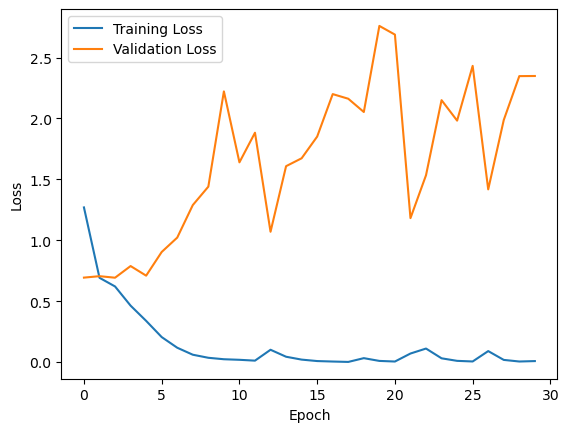

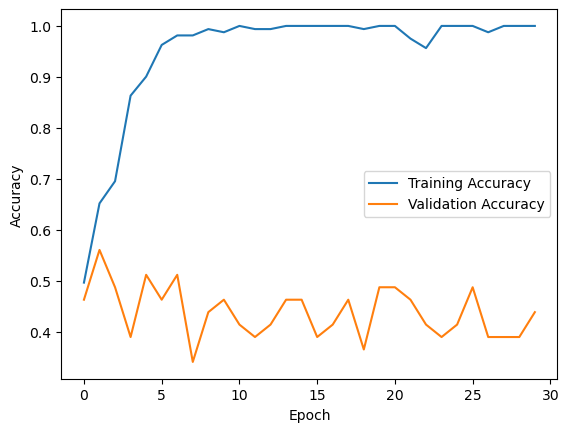

In [11]:
# You can choose any suitable number depending on your GPU memory
batch_size = 5  

# Train the model on GPUs and save the history:
with tf.device('/GPU:0'):  # '/CPU:0' to run on CPU, '/GPU:0' to run on the first available GPU
    history=model.fit(X_train, y_train, epochs=30, batch_size=batch_size, validation_data=(X_test, y_test))

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch', color='black')
plt.ylabel('Loss', color='black')
plt.legend()
plt.tick_params(axis='x', colors='black')  # Change x and y tick label colors to black
plt.tick_params(axis='y', colors='black')  # Change x and y tick label colors to black
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch', color='black')
plt.ylabel('Accuracy', color='black')
plt.legend()
plt.tick_params(axis='x', colors='black')  # Change x and y tick label colors to black
plt.tick_params(axis='y', colors='black')  # Change x and y tick label colors to black
plt.show()

['cat' 'dog']
1/1 [==============================] - 0s 53ms/step


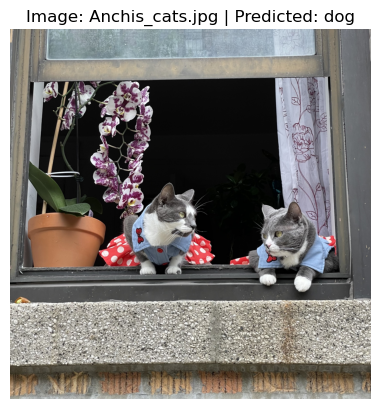

1/1 [==============================] - 0s 12ms/step


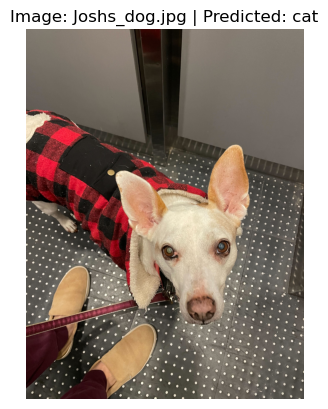

1/1 [==============================] - 0s 11ms/step


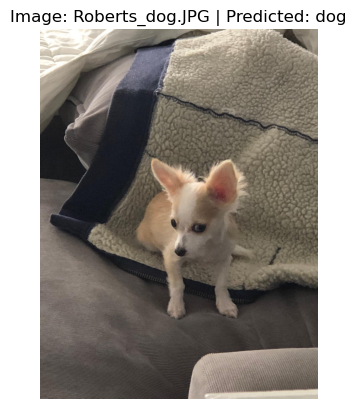

1/1 [==============================] - 0s 12ms/step


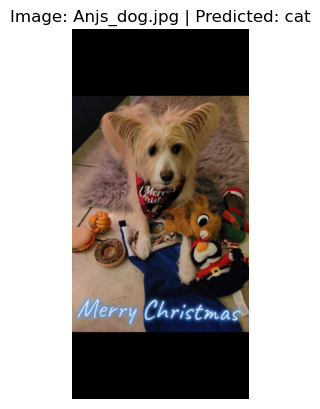

1/1 [==============================] - 0s 12ms/step


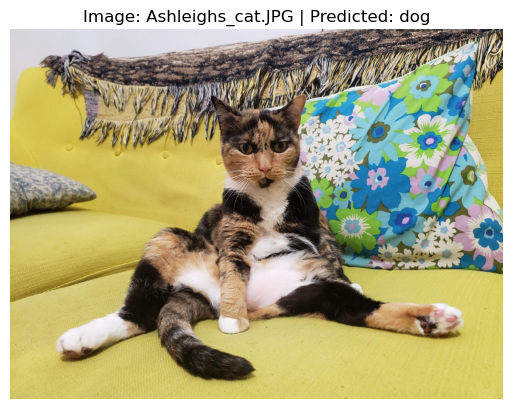

1/1 [==============================] - 0s 12ms/step


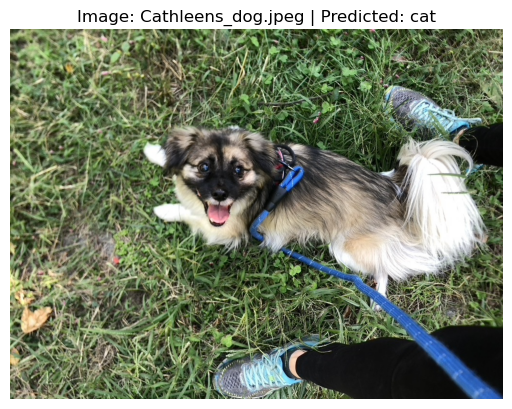

1/1 [==============================] - 0s 12ms/step


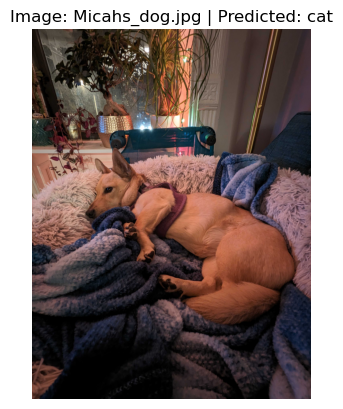

1/1 [==============================] - 0s 12ms/step


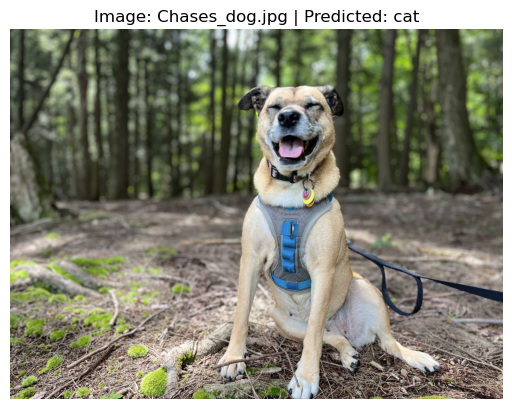

1/1 [==============================] - 0s 12ms/step


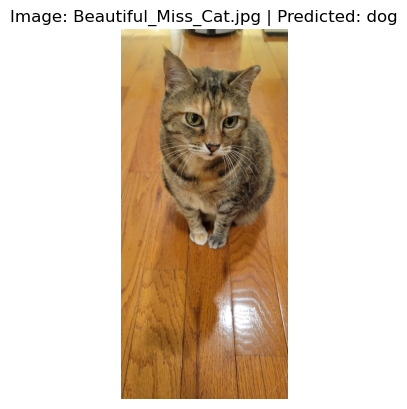

In [12]:
# Run prediction on your images

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

print(le.classes_)  # This will show you the order in which classes were encoded, e.g., ['Cat', 'Dog']

# Directory containing images you wish to predict
image_folder = "/home/semc/Aygul_DL/semc_pets"

# Load and preprocess each image and make predictions
for img_name in os.listdir(image_folder):
    img_path = os.path.join(image_folder, img_name)
    
    # Show the original image
    img_original = image.load_img(img_path)
    plt.imshow(img_original)
    plt.axis("off")
    
    # Preprocess the image
    img_width, img_height, colors = 224, 224, 3  # Replace with the input shape you used for your model
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Make a prediction
    prediction_value = model.predict(img_array)[0][0]  # This will be a float between 0 and 1
    
    # Interpret the prediction based on a threshold
    threshold = 0.5
    if prediction_value > threshold:
        predicted_label = le.inverse_transform([1])[0]
    else:
        predicted_label = le.inverse_transform([0])[0]
    
    # Display the prediction with the original image and its name
    plt.title(f"Image: {img_name} | Predicted: {predicted_label}")
    plt.show()